In [2]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import Rosenbrock
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [46]:
# unsure of how exactly to deal with the different cases
# for now I am just taking negative log transform of cases described
# ask about the way I've done the inequalities
# can implement c to be the running minimum also just by modifying properties in this class.
class Lm_rosenbrock(Rosenbrock):
    """Rosenbrock function

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self, dim=10,ep = 1):
        self.ep = ep
        self.dim = dim
        self.c = 0.25
        self.H_ys = []
        self.beta = 1/ep
        self.min = 0
        self.minimum = np.ones(dim)
        self.lb = -2.048 * np.ones(dim)
        self.ub = 2.048 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional Rosenbrock function \n" + "Global optimum: f(1,1,...,1) = 0"

        # linear f
    def eval1(self, x):
        """Evaluate the modified Rosenbrock function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified Rosenbrock function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
       # if H_y <= self.c:
        #    self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


hi
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246

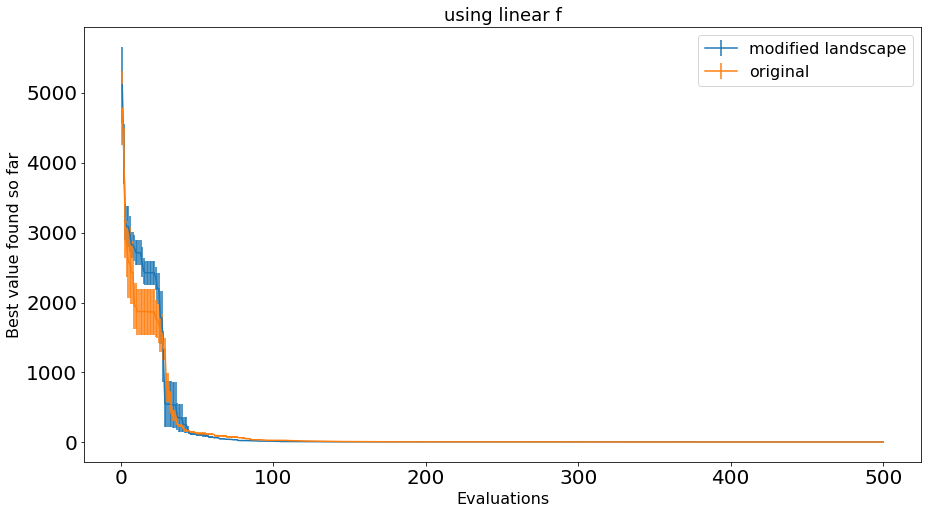

In [38]:
def plotter():
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    num_threads = 4
    max_evals = 500
    num_runs = 5
    lm_rosenbrock = Lm_rosenbrock(dim=10)
    rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
    slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))

    results_async1 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        # can change landscape by changing eval1 to eval2 or eval3 based on preferance
        controller1 = SerialController(objective=lm_rosenbrock.eval1)
        # can just change this to DYCORS for the more new strategy.
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller1.run()
        results_async1[:, i] = np.array(
            [H_y for H_y in lm_rosenbrock.H_ys[i * max_evals:] if H_y is not None])
        
    results_async2 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        controller2 = SerialController(objective=lm_rosenbrock.eval)
        controller2.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller2.run()
        results_async2[:, i] = np.array(
            [o.value for o in controller2.fevals if o.value is not None])

    plt.figure(figsize=(15, 8))
    for results in [results_async1, results_async2]:
        fvals = np.minimum.accumulate(results) 
        print('hi')
        print(np.arange(max_evals)+1)
        print('bye')
        print(np.minimum.accumulate(results) )
        plt.errorbar(np.arange(max_evals)+1, y=np.mean(fvals, axis=1), 
                     yerr=np.std(fvals, axis=1)/np.sqrt(float(num_runs)))

#     plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using linear f',fontsize = 18)
    plt.show()



#example_simple(12)
random.seed(0)
np.random.seed(0)
plotter()

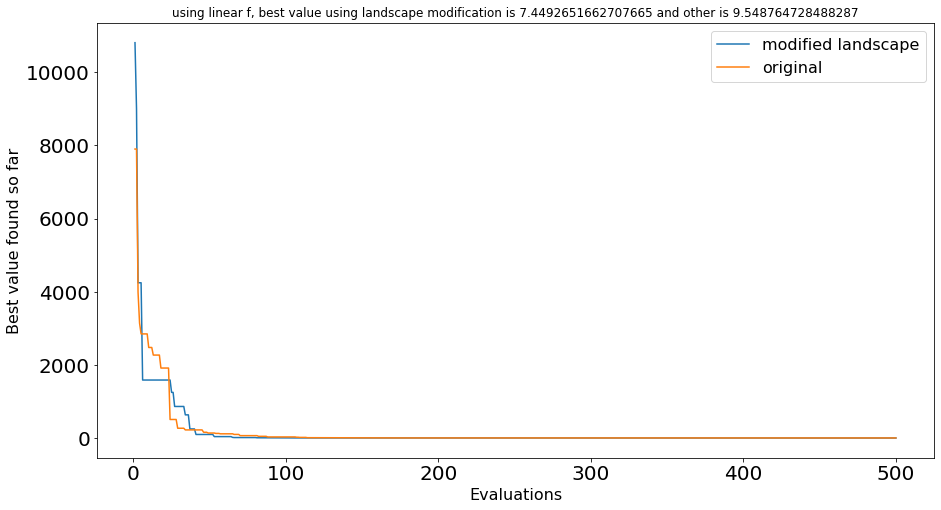

(7.4492651662707665, 9.548764728488287)

In [47]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/surrogate optimization research/pySOT-master/rosenbrock_results/0.25_c'
# when I do it serially and also not asynchronously I am able to make it deterministic
def example_simple(state,path,i):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 500
    
    lm_rosenbrock = Lm_rosenbrock(dim=10)
    rbf = RBFInterpolant(dim=lm_rosenbrock.dim, lb=lm_rosenbrock.lb, ub=lm_rosenbrock.ub, kernel=CubicKernel(), tail=LinearTail(lm_rosenbrock.dim))
    slhd = SymmetricLatinHypercube(dim=lm_rosenbrock.dim, num_pts=2 * (lm_rosenbrock.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_rosenbrock.eval1)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result = controller.run()
    l1 = lm_rosenbrock.H_ys


    # Create a strategy and a controller
    
    controller1 = SerialController(objective=lm_rosenbrock.eval)
    controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_rosenbrock, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )


    # Run the optimization strategy
    result1 = controller1.run()
    l2 = np.zeros(max_evals)
    l2 = np.array(
            [o.value for o in controller1.fevals if o.value is not None])
    
    plt.figure(figsize=(15, 8))
    for results in [l1, l2]:
        fvals = np.minimum.accumulate(results)
        plt.errorbar(np.arange(max_evals)+1, y=fvals)

    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
              format(lm_rosenbrock.eval(result.params[0]),lm_rosenbrock.eval(result1.params[0])),
              fontsize = 12)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 300)
    plt.show()

    
    return lm_rosenbrock.eval(result.params[0]),lm_rosenbrock.eval(result1.params[0])
    


example_simple(42,path,1)

In [48]:

def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    folder = path
    for i in range(times):
        res = example_simple(i,path,i)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

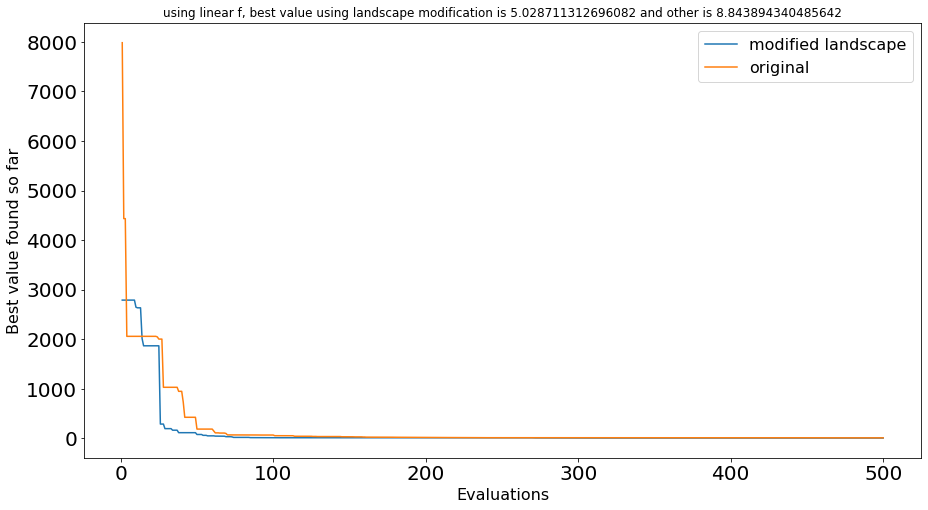

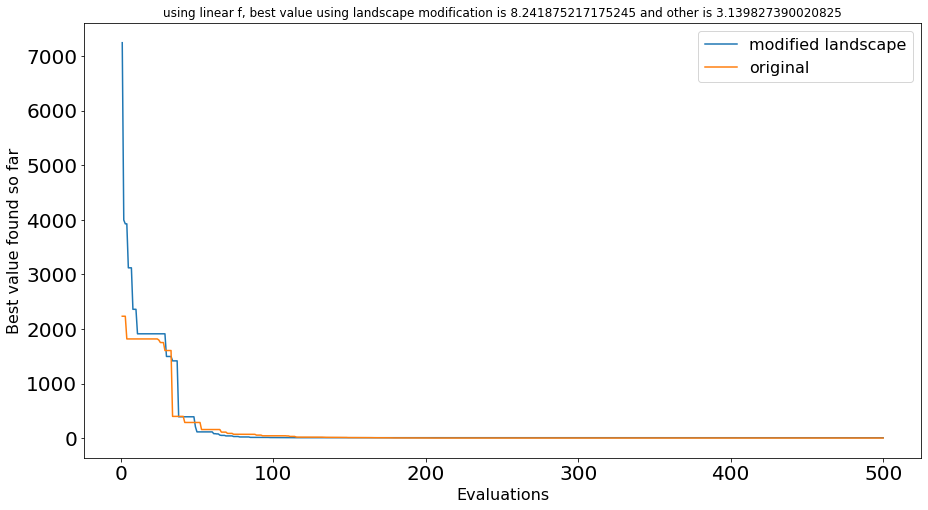

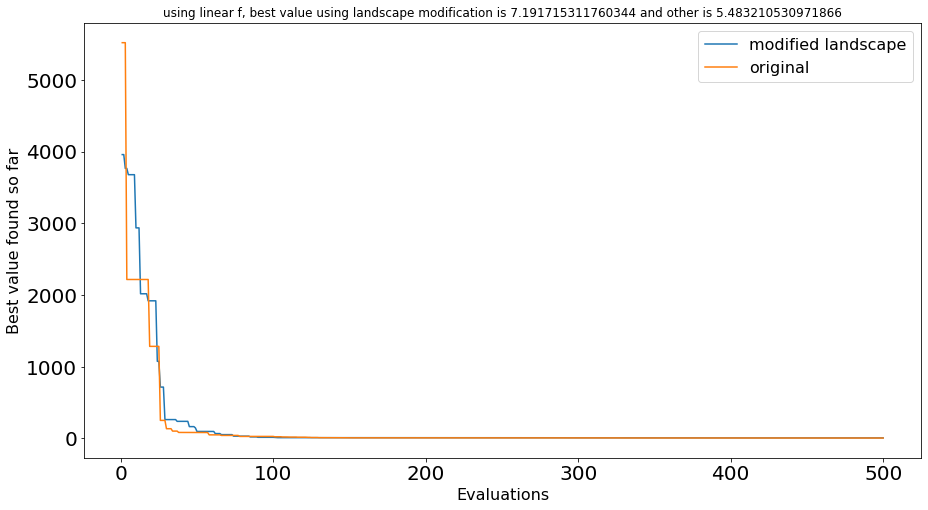

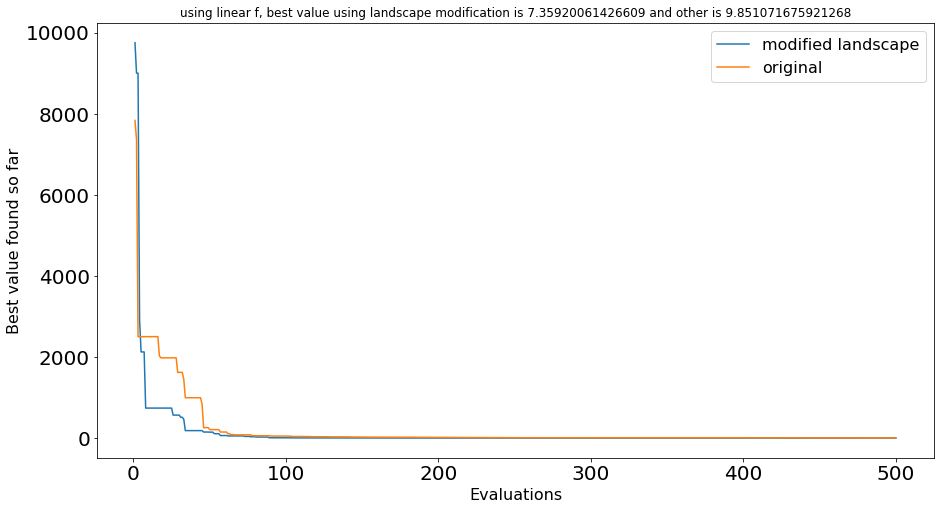

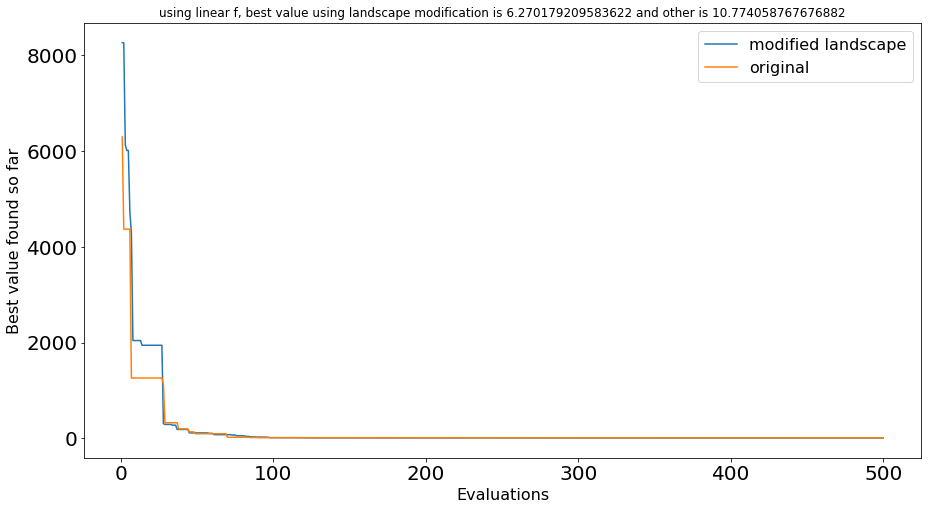

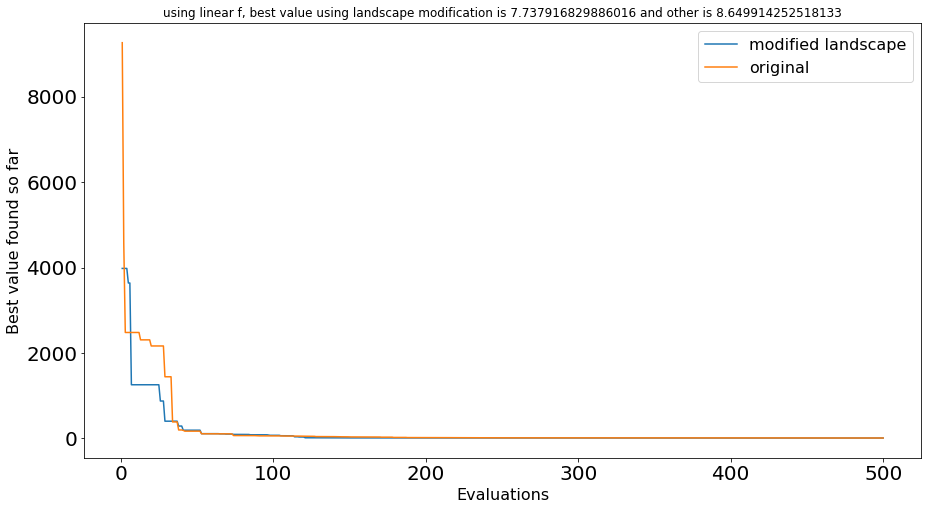

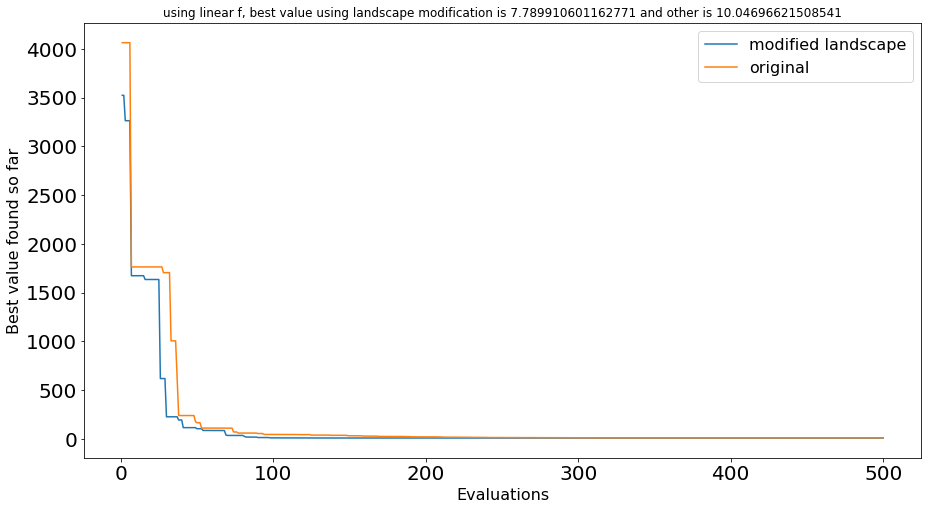

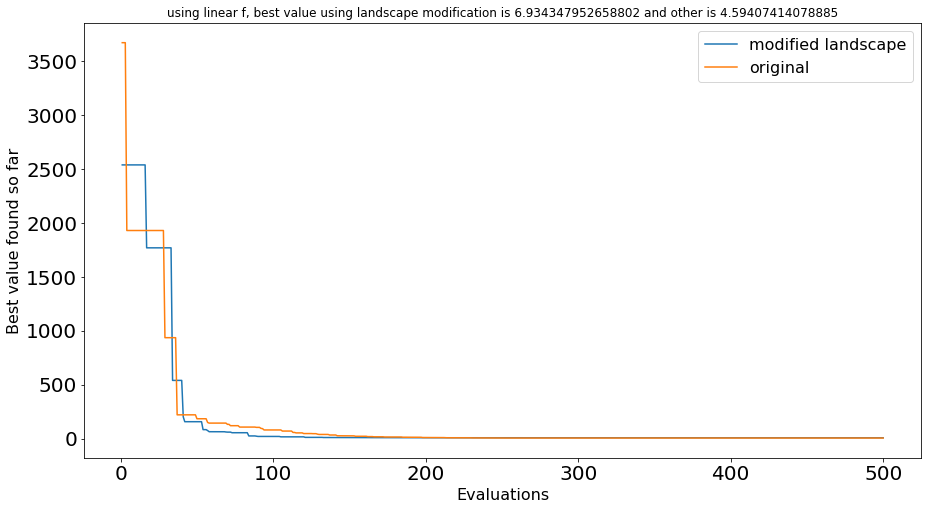

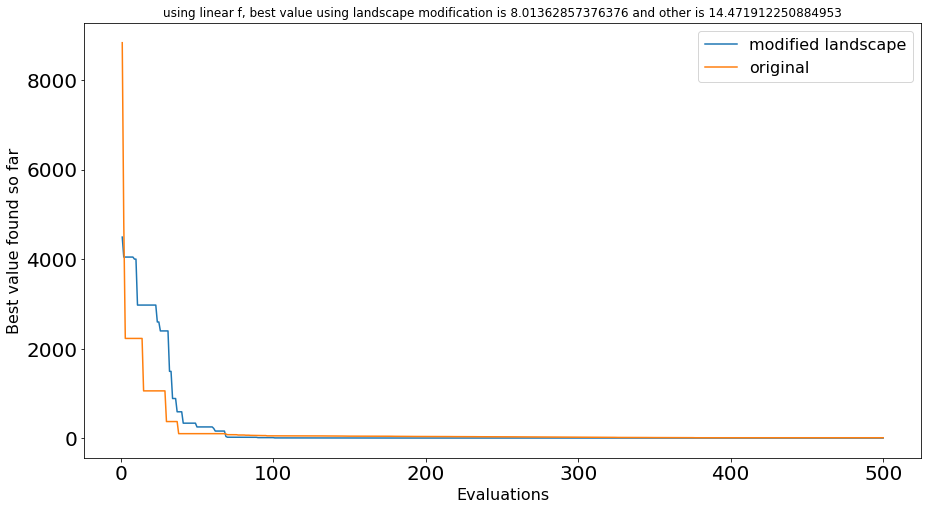

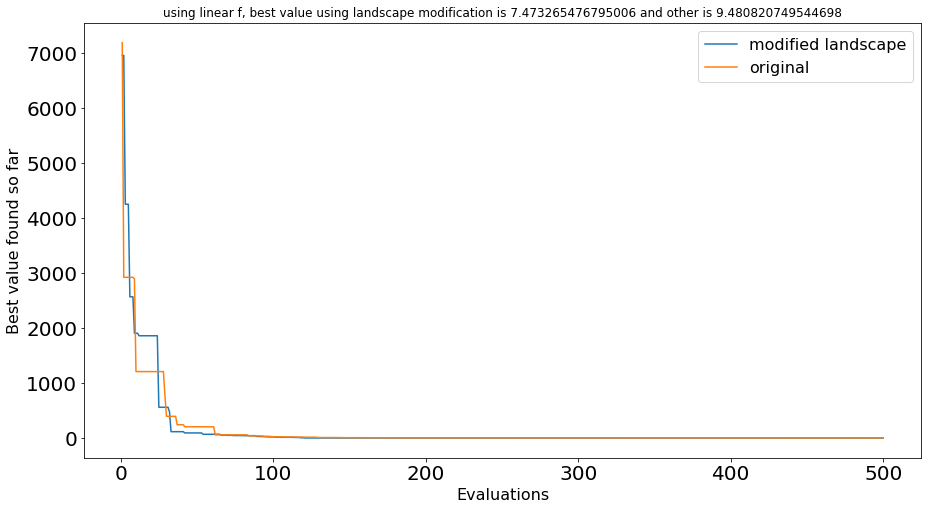

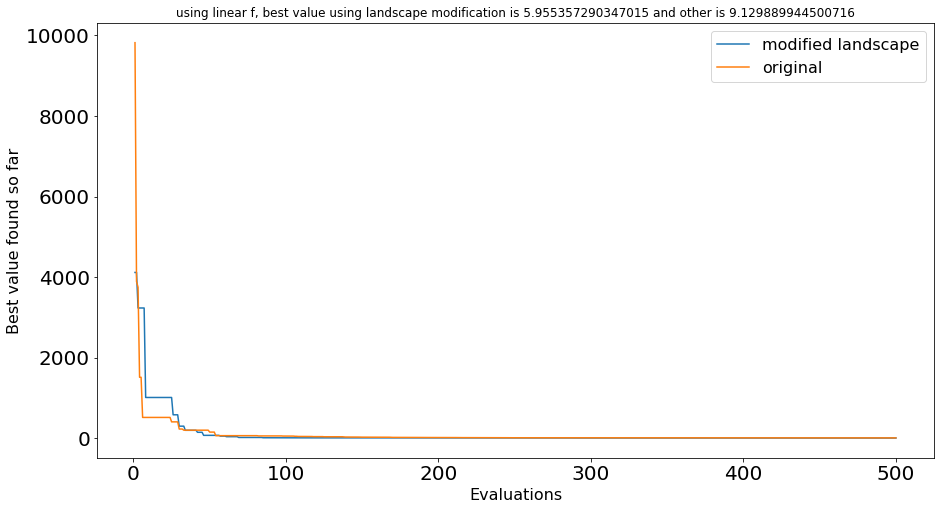

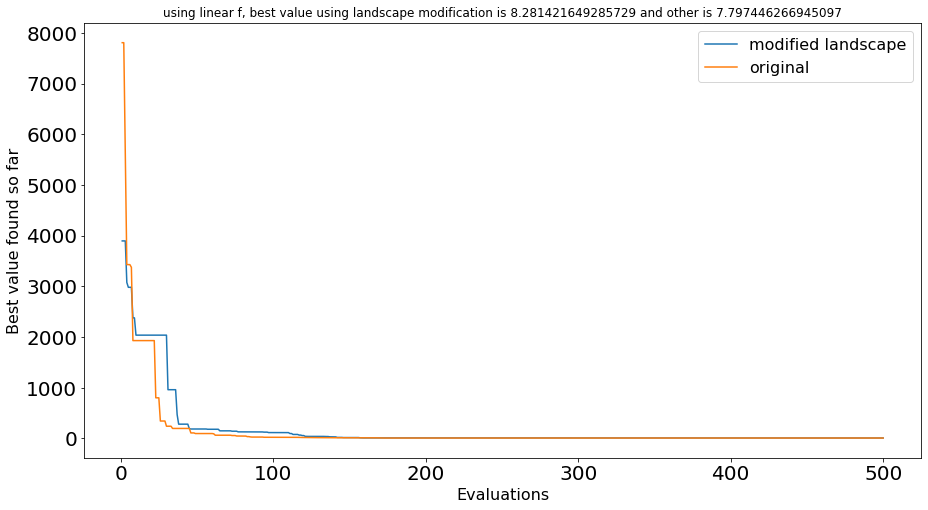

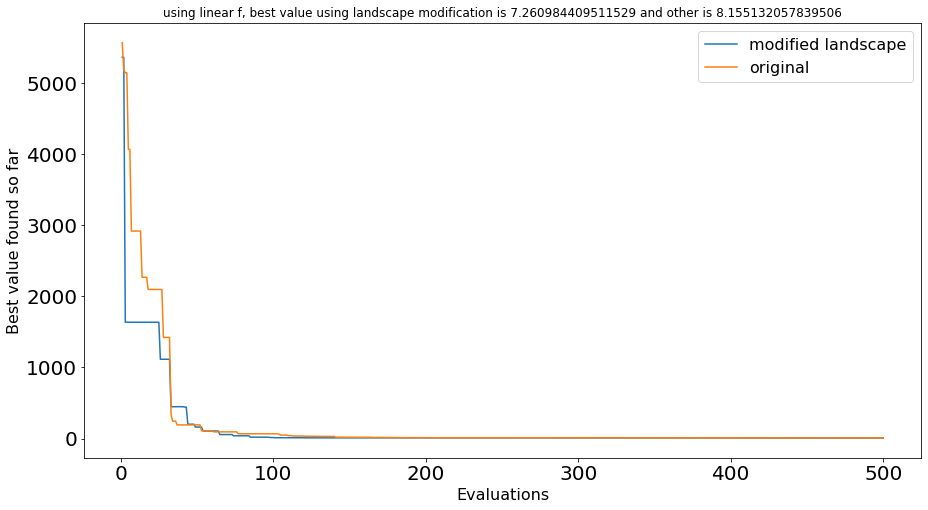

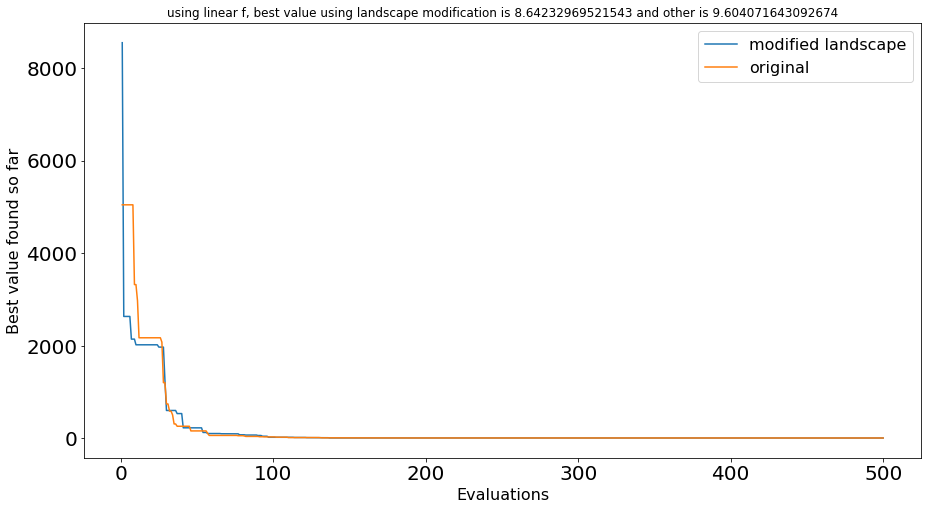

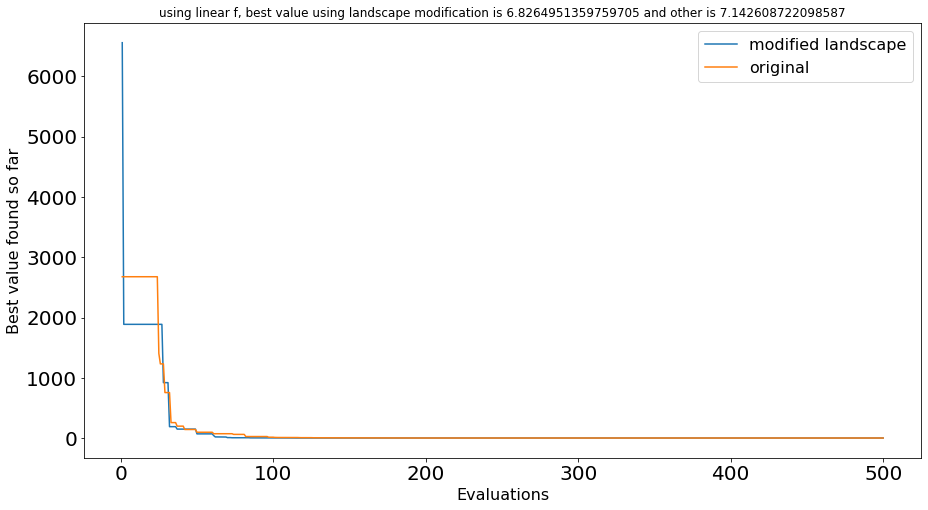

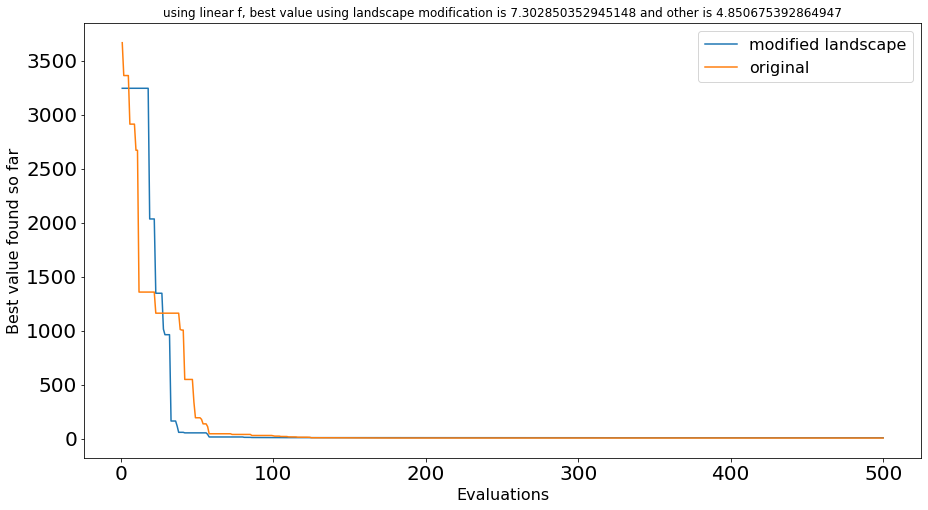

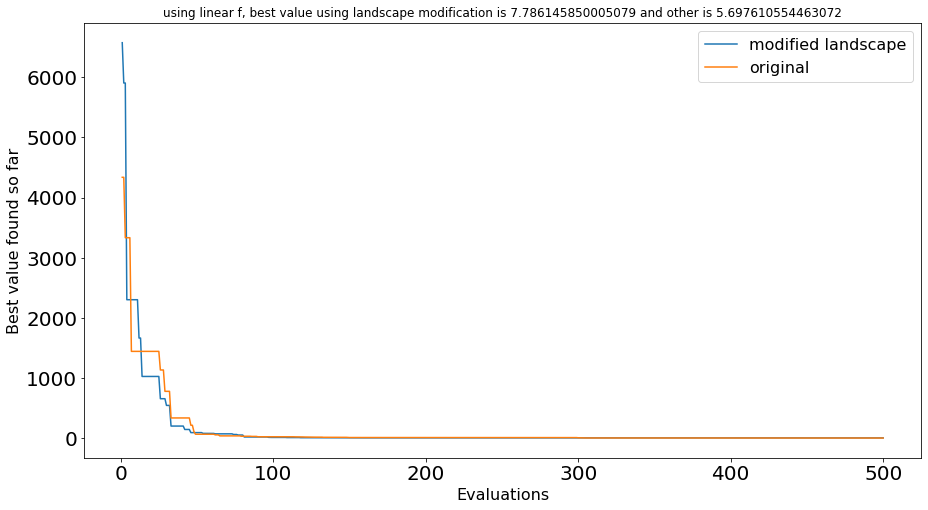

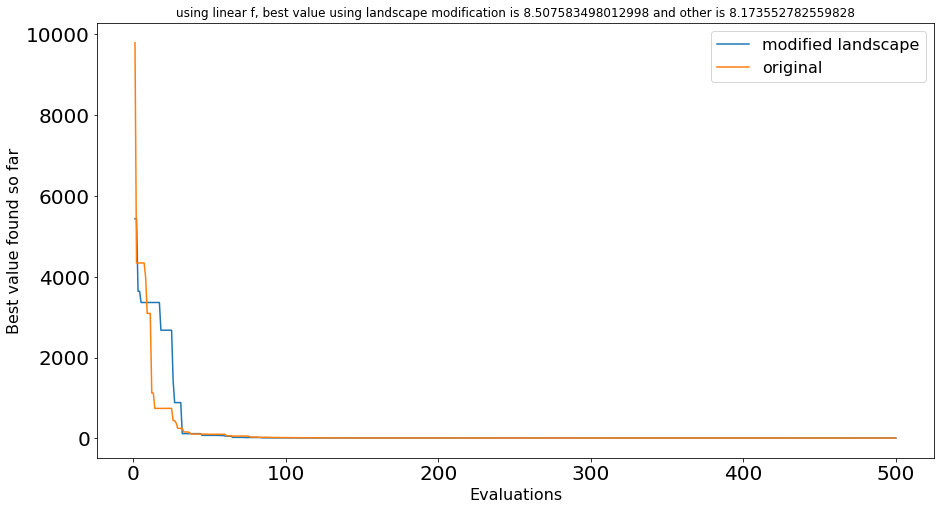

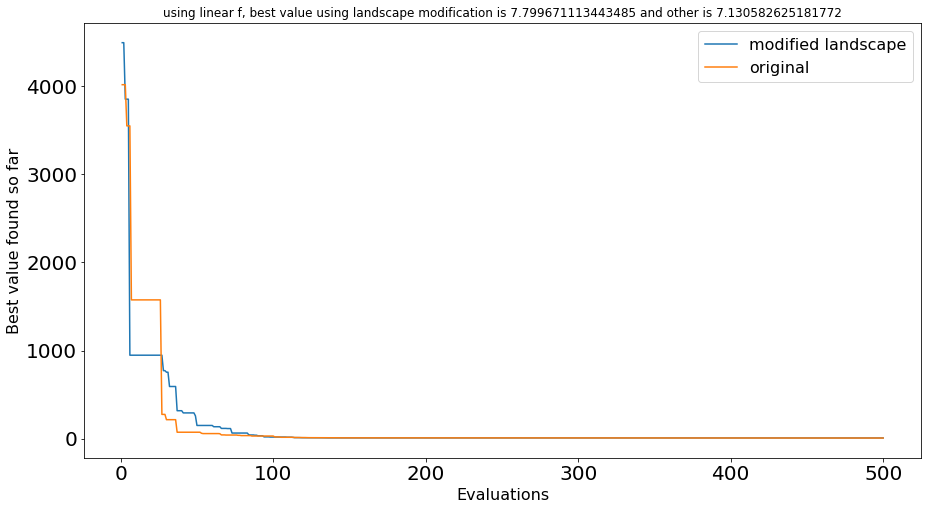

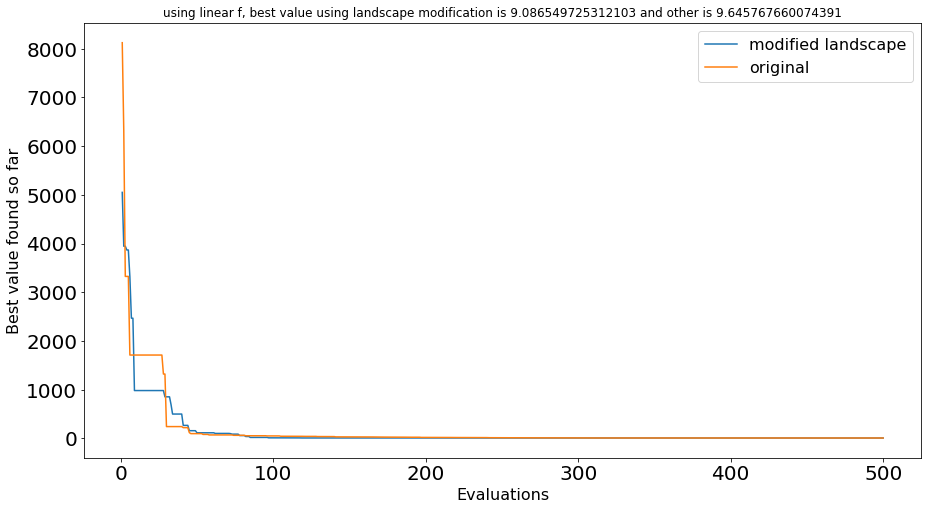

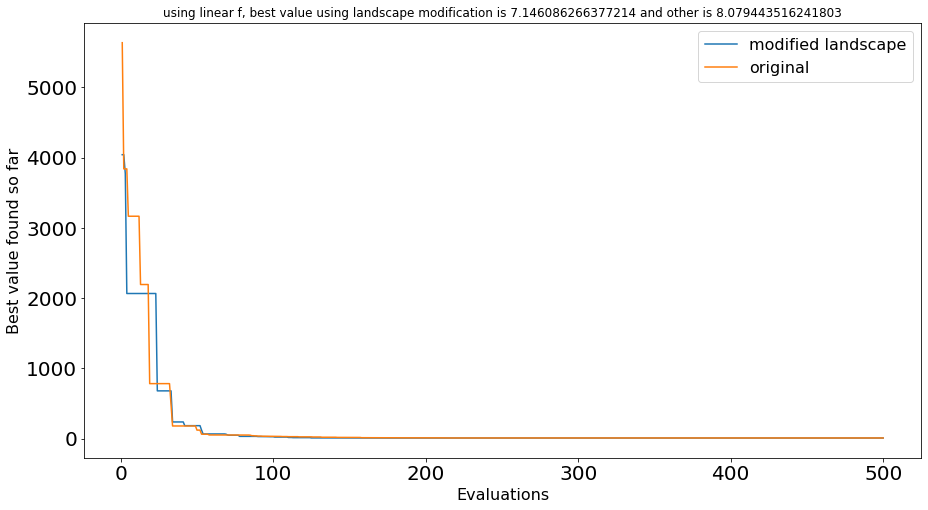

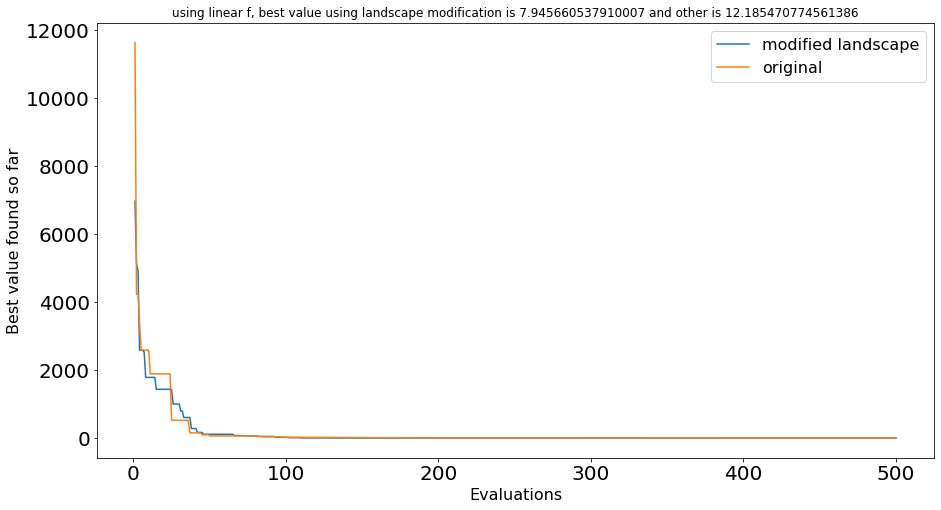

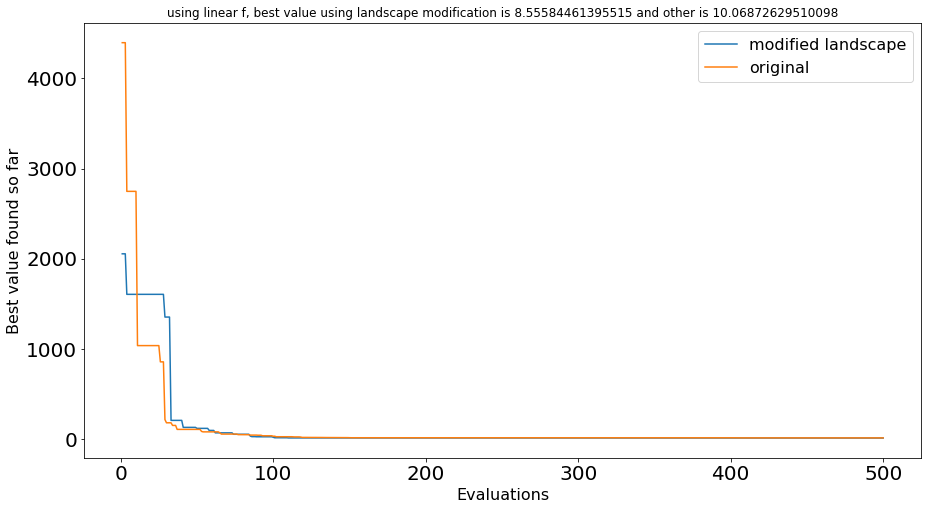

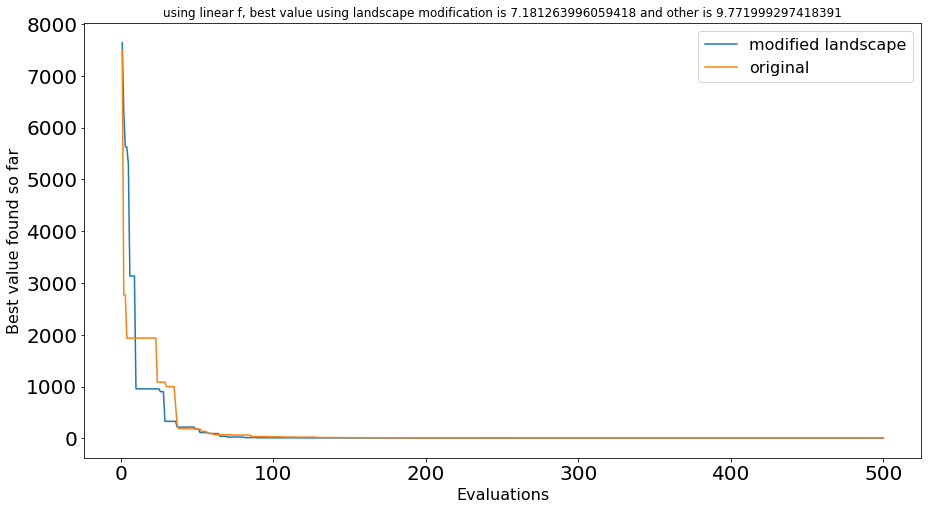

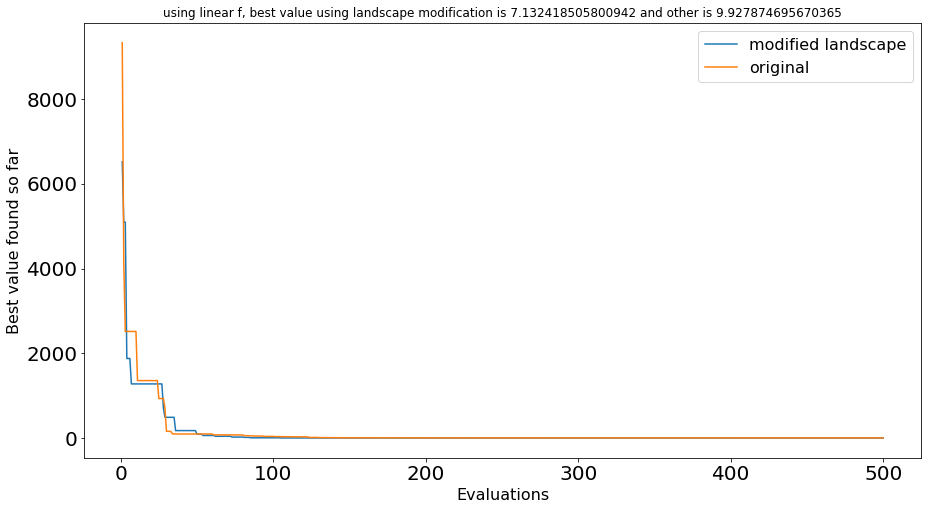

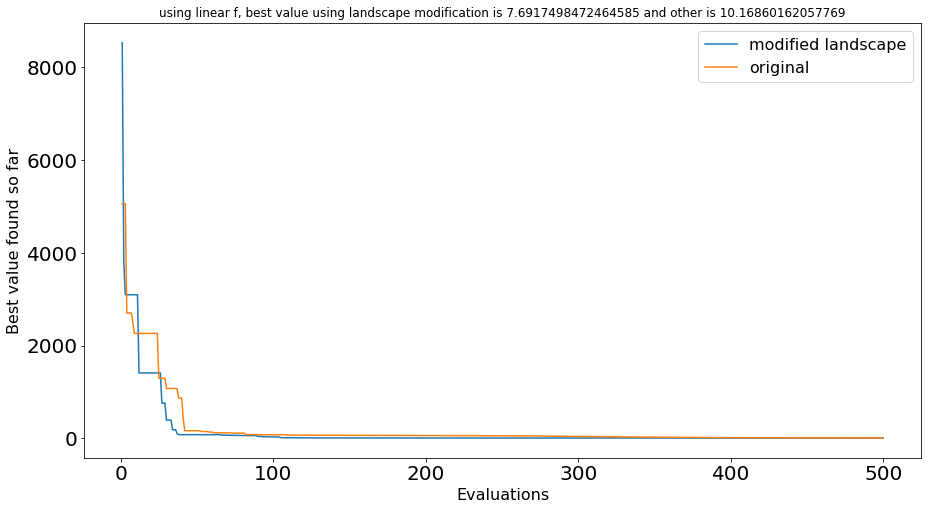

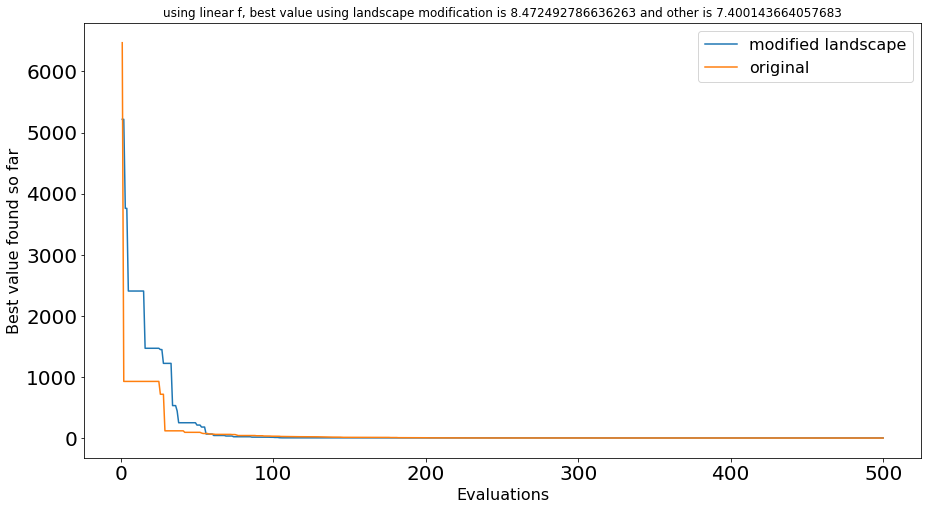

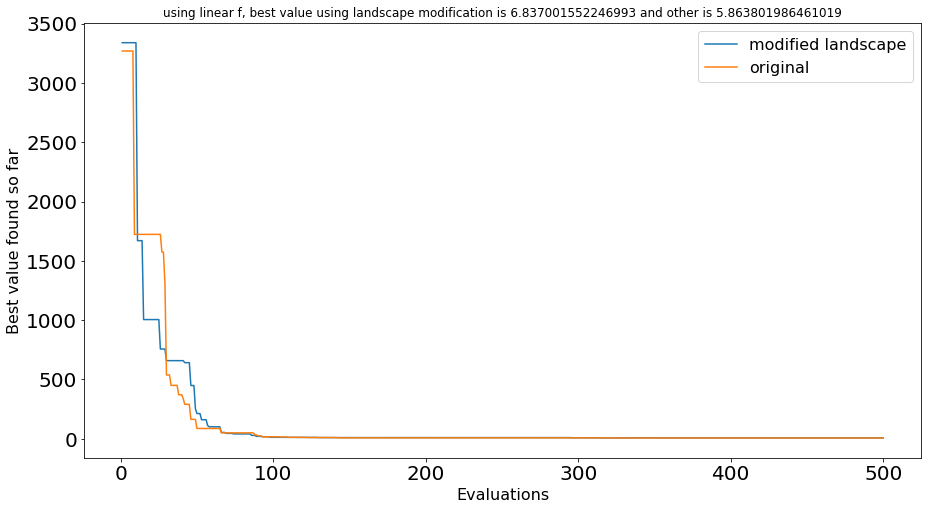

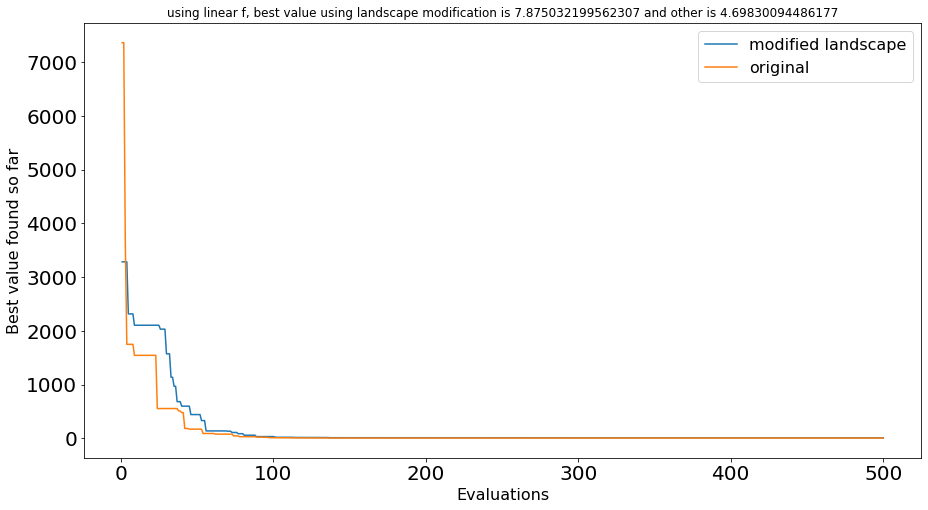

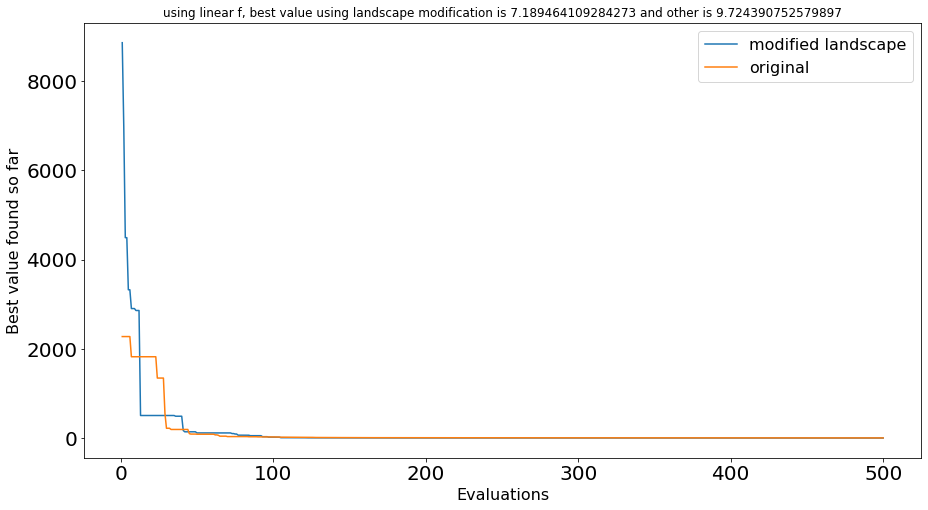

landscape modified was better 19 times and was worse 11 times
mean of landscape modified is 7.517238474496041
mean of non landscape modified is 8.351728050368337
median of landscape modified is 7.582507662020732
median of non landscape modified is 8.746904296501889
best result of landscape modified is 5.028711312696082
best of non landscape modified is 3.139827390020825
worst result of landscape modified is 9.086549725312103
worst of non landscape modified is 14.471912250884953


([5.028711312696082,
  8.241875217175245,
  7.191715311760344,
  7.35920061426609,
  6.270179209583622,
  7.737916829886016,
  7.789910601162771,
  6.934347952658802,
  8.01362857376376,
  7.473265476795006,
  5.955357290347015,
  8.281421649285729,
  7.260984409511529,
  8.64232969521543,
  6.8264951359759705,
  7.302850352945148,
  7.786145850005079,
  8.507583498012998,
  7.799671113443485,
  9.086549725312103,
  7.146086266377214,
  7.945660537910007,
  8.55584461395515,
  7.181263996059418,
  7.132418505800942,
  7.6917498472464585,
  8.472492786636263,
  6.837001552246993,
  7.875032199562307,
  7.189464109284273],
 [8.843894340485642,
  3.139827390020825,
  5.483210530971866,
  9.851071675921268,
  10.774058767676882,
  8.649914252518133,
  10.04696621508541,
  4.59407414078885,
  14.471912250884953,
  9.480820749544698,
  9.129889944500716,
  7.797446266945097,
  8.155132057839506,
  9.604071643092674,
  7.142608722098587,
  4.850675392864947,
  5.697610554463072,
  8.173552782

In [49]:
checker(30,path)

In [14]:
path

'/Users/venkatkrishnakarumanchi/Desktop/surrogate optimization research/pySOT-master/rosenbrock_results/adaptive_c'